In [12]:
from typing import Dict, List

import yaml
import tensorflow as tf
from PIL import Image
from pydantic import FilePath

from clipkit.cliplayers import ClipMe
from clipkit.utils import get_image_model, get_text_model


def prepare_image(image_path: FilePath) -> tf.Tensor:
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img, 288, 288)[tf.newaxis, :, :, :]
    return img


def clip_data_prep(image_path: FilePath, captions: List[str], text_max_len: int) -> Dict:
    img = prepare_image(image_path)
    enc = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=text_max_len,
        return_tensors="np",
    )
    ids, mask = enc["input_ids"], enc["attention_mask"]
    inputs = {"pixel_values": img, "input_ids": ids, "attention_mask": mask}
    return inputs


def get_embeddings(image_path: FilePath, captions: List[str], text_max_len: int):
    data_sample = clip_data_prep(
        image_path=image_path, captions=captions, text_max_len=text_max_len
    )
    prediction = CLIPME(data_sample, training=False)
    im_vect = tf.math.l2_normalize(prediction[0], axis=-1)
    txt_vetc = tf.math.l2_normalize(prediction[1], axis=-1)
    return im_vect, txt_vetc


def compute_scores(
    image_vector: tf.Tensor,
    text_vector: tf.Tensor,
    captions: List[str],
    top_pred_count: int = 3,
):
    compute_sim = image_vector @ tf.transpose(text_vector)
    out = captions[tf.argmax(compute_sim, axis=-1)[0].numpy()]
    indices = tf.argsort(compute_sim, direction="DESCENDING")[0][:top_pred_count].numpy()
    scores = compute_sim[0].numpy()[indices]
    scores = scores.tolist()
    labels = [captions[s] for s in indices]
    output_preds = dict(zip(labels, scores))
    return output_preds

#### Setting up testing
* Load the ```config.yaml``` file used for training.

In [7]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

data_cfg = cfg["Dataset"]
model_cfg = cfg["Model"]
train_cfg = cfg["Training"]


image_model = get_image_model(
    model_name=model_cfg["image_encoder"],
    active_layers_image_model=model_cfg["tune_image_layers_count"],
)


text_model, tokenizer = get_text_model(
    model_id=model_cfg["text_encoder"], trainable=model_cfg["tune_text_layers"]
)

I0000 00:00:1751571926.103200   36339 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6217 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectr

#### Loading the trained Model
* Here We load the best model from our model directory. ```checkpoint_path``` is our model dir.
* Restore to the latest ckpt.

In [9]:
# ckpt dir
checkpoint_path = "model_ckpt/"

# Initialize
CLIPME = ClipMe(
    image_model_id=image_model, text_model_id=text_model, proj_dim=model_cfg["proj_dim"]
)

## Build
_ = CLIPME(
    {
        "pixel_values": tf.ones((1, 224, 224, 3)),
        "input_ids": tf.ones((1, 12), tf.int32),
        "attention_mask": tf.ones((1, 12), tf.int32),
    }
)

# Restore weights
ckpt = tf.train.Checkpoint(net=CLIPME)
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

I0000 00:00:1751571965.036065   36339 cuda_dnn.cc:529] Loaded cuDNN version 90300


#### Lets Go! Zero Shot Classification
* Given a set of captions and an Image we can compute the closest matches.
* The advantage is with less data and data augumenration techniques we can really build powerful models.

In [10]:
captions = [
    "the breed is shitzu",
    "the breed is norweight_elkahound",
    "the breed is Maltese",
    "the breed is irish_grayhound",
    "the breed is japanese_spaniel",
    "the breed is bloodhound",
    "the breed is rotweiller",
    "the breed is Komondor",
    "the breed is redbone",
]

{'the breed is irish_grayhound': 0.3513599634170532, 'the breed is norweight_elkahound': 0.08865052461624146, 'the breed is Komondor': 0.08249077200889587}


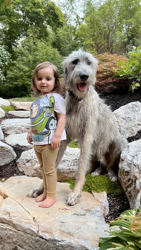

In [15]:
image_id = "IMG_2643.jpg"  # image_path
image_vect, text_vect = get_embeddings(
    image_path=image_id, captions=captions, text_max_len=model_cfg["max_length"]
)
predictions = compute_scores(
    image_vector=image_vect, text_vector=text_vect, captions=captions, top_pred_count=3
)
print(predictions)
im = Image.open(image_id)
im.thumbnail((250, 250))
im